In [1]:
from collections import defaultdict
import numpy as np
import tabulation
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [2]:
import sys, os
sys.path.append(os.path.abspath("../../"))

For some unknown reason we need to import numpy before my elements. Doing that must add some things to the path that my code here needs somehow?

I won't bother with the elements vs no elements thing, since that gets taken care of during runtime when adding things to cells. I'll only worry about continuous vs discrete. All other things have been tested to be the same under all other conditions.

In [3]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snia_enrich_ia_elts_cluster_discrete import lib as snia_discrete
from snia_enrich_ia_elts_cluster          import lib as snia_continuous
from snii_enrich_ia_elts_cluster_discrete import lib as snii_discrete
from snii_enrich_ia_elts_cluster          import lib as snii_continuous
from agb_enrich_ia_elts_cluster_discrete  import lib as agb
from wind_enrich_ia_elts_cluster_discrete import lib as winds

In [4]:
core.detailed_enrichment_init()
snia_discrete.detailed_enrichment_init()
snia_continuous.detailed_enrichment_init()
snii_discrete.detailed_enrichment_init()
snii_discrete.init_rand()
snii_continuous.detailed_enrichment_init()
agb.detailed_enrichment_init()
winds.detailed_enrichment_init()

In [5]:
bpl.presentation_style()

In [6]:
def art_mass_loss_rate(age, m_star):
    if (age > 2.75423e6):
        return m_star * (0.12486-3.89635e-3*np.log(age)) / age 
    else:
        return 0

In [7]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.08, 50, total_mass=1)

First try to see if the integration is okay.

In [8]:

# frac_N_SN = 0.0109743508039993  # SN / solar mass

In [9]:
frac_N_SN_II = integrate.quad(imf.normalized_dn_dm, 8.0, 50.0)[0]

In [10]:
integrate.quad(imf.normalized_dn_dm, 0.08, 50.0)[0]

1.8195539821139628

In [11]:
core.imf_integral_py(0.08, 50.0)

1.8195539834437708

In [12]:
frac_N_SN_Ia = 1.6E-3

In [13]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 0.9, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.3f} {:.3f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

In [14]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 50.0, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.1f} {:.1f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

Figure out what to expect for the SN history

In [15]:
ssp_art = tabulation.SSPYields("Kroupa", 0.08, 50, 1,
                               "Raiteri_96", 
                               "Kobayashi_06", 0.5, 8, 50,
                               "art power law", "Nomoto_18", {"number_sn_ia":0.0016},
                               "NuGrid", 0.08, 8)

In [16]:
frac_E_py = ssp_art.energy_erg_yr_supernovae(1E6, 1E8, 0.02) * 1E8  # ergs / solar mass

In [17]:
def integrand_energy(mass):
    imf = ssp_art.imf.normalized_dn_dm(mass)
    energy_sn = 1E51
    if mass > 20.0: 
        energy_hn = snii_discrete.hn_energy_py(mass)
        energy = 0.5 * energy_sn + 0.5 * energy_hn
    else:
        energy = energy_sn
    return imf * energy

frac_E_art = integrate.quad(integrand_energy, 8.0, 50.0)[0]

In [18]:
print(frac_E_py)
print(frac_E_art)

3.1862716460039605e+49
3.1862716467713695e+49


In [19]:
frac_E = frac_E_art

Then attempt to build a SN history

In [20]:
def ceil_to_nearest(num, scale):
    test_values = np.arange(0, num+2*scale, scale)
    for val in test_values:
        if val - scale > num:
            return val

In [21]:
dt_sn = 1E5
dt_agb = 1E6

In [22]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        split = ceil_to_nearest(lt.lifetime(8.0, z), dt_sn)
        times[z] = np.concatenate([np.arange(0, split, dt_sn),
                                   np.arange(split, 14E9, dt_agb)])
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [23]:
generate_times([0.02, 0.01, 0.004, 0.001, 0.0005, 0.0001])

/Users/gillenb/miniconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [24]:
solar_metallicities = {"Z":0.02, "C":2.78E-3, "N":8.14E-4, "O":7.56E-3,
                       "Mg":6.45E-4, "S":4.79E-4, "Ca":6.41E-5, "Fe":1.23E-3}

In [25]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe"]
all_fields = elts + ["Z_II", "Z_Ia", "Z_AGB", "Z", "total", "E", "N_SN", "N_SN_left"]
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}
agb_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
           "Z_AGB": 7, "Z": 7, "total":8}
sn_ia_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_Ia": 7, "Z": 7, "total": 7, "E": 8, "N_SN_left": 9}
# The raw yields doesn't return some elements, since those are scaled based on
# the metallicity of the star
agb_idxs_yields = {"C": 0, "N": 1, "O":2, "Mg":3, "Z_AGB":4, "total": 5}

class SNHistory(object):
    def __init__(self, stellar_mass, z, discrete=True, verbose=False):
        self.mass = stellar_mass
        self.z = z
        
        self.age_50 = lt.lifetime(50.0, self.z)
        
        self.times = times[z]
        self.turnoff_masses = turnoff_masses[z]
        
        self.discrete = discrete
        
        # handle which functions to call
        if discrete:
            self.sn_ii_func = snii_discrete.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_discrete.sn_ia_core_py
        else:
            self.sn_ii_func = snii_continuous.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_continuous.sn_ia_core_py
        
        self.sn_ia_start = lt.lifetime(8.0, self.z)
        
        self.yields = defaultdict(list)
        self.cumulative = defaultdict(list)
        
        self.yields_sn_ii = defaultdict(list)
        self.cumulative_sn_ii = defaultdict(list)
        
        self.yields_sn_ia = defaultdict(list)
        self.cumulative_sn_ia = defaultdict(list)
        
        self.yields_agb = defaultdict(list)
        self.cumulative_agb = defaultdict(list)
        
        self.yields_winds = defaultdict(list)
        self.cumulative_winds = defaultdict(list)
        
        self.handle_history(verbose)
        
    def handle_history(self, verbose=False):
        self.unexploded_sn_ii = 0
        self.unexploded_sn_ia = 0
        
        for idx in range(len(self.turnoff_masses) - 1):
            m_now  = self.turnoff_masses[idx]
            m_next = self.turnoff_masses[idx+1]
            age_now = self.times[idx]
            age_next = self.times[idx+1]
            dt = age_next - age_now
            sn_ii_yields = self.sn_ii_func(self.unexploded_sn_ii, m_now, m_next, self.mass, self.z)
            agb_yields = agb.get_ejecta_agb_py(m_now, m_next, self.mass, self.z,
                                               (self.z/0.02) * solar_metallicities["S"],
                                               (self.z/0.02) * solar_metallicities["Ca"],
                                               (self.z/0.02) * solar_metallicities["Fe"])
            sn_ia_yields = self.sn_ia_func(self.unexploded_sn_ia, age_now, dt,
                                           self.mass, self.z, self.sn_ia_start)
            winds_yields = winds.get_ejecta_winds_py(age_now, age_next, 
                                                     m_now, m_next, 
                                                     self.mass, self.z, self.age_50)
            
            # handle SN numbers
            if self.discrete:
                self.unexploded_sn_ii = sn_ii_yields[sn_ii_idxs["N_SN_left"]]
                self.unexploded_sn_ia = sn_ia_yields[sn_ia_idxs["N_SN_left"]]
#             print(m_now, m_next, yields[self.idxs["N_SN"]], self.unexploded_sn)
            if verbose:
                print("{:8.4f} {:8.4f} {:8.4f} {:8.4f}".format(m_now, m_next, sn_ii_yields[sn_ii_idxs["N_SN"]], self.unexploded_sn))
            
            for field in all_fields:
                if field in sn_ii_idxs:
                    this_sn_ii_yield = sn_ii_yields[sn_ii_idxs[field]]
                else:
                    this_sn_ii_yield = 0
                    
                if field in sn_ia_idxs:
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs[field]]
                elif field == "N_SN":
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs["E"]] / 2E51
                else:
                    this_sn_ia_yield = 0
                    
                
                if field in agb_idxs:
                    this_agb_yield = agb_yields[agb_idxs[field]]
                else:
                    this_agb_yield = 0
                    
                if field == "total":
                    this_wind_yield = winds_yields
                elif field in elts:
                    this_wind_yield = winds_yields * (self.z/0.02) * solar_metallicities[field]
                else:
                    this_wind_yield = 0
                
                total_yield = this_sn_ii_yield + this_sn_ia_yield + this_agb_yield + this_wind_yield
                
                self.yields_sn_ii[field].append(this_sn_ii_yield / dt)
                self.yields_sn_ia[field].append(this_sn_ia_yield / dt)
                self.yields_agb[field].append(this_agb_yield / dt)
                self.yields_winds[field].append(this_wind_yield / dt)
                self.yields[field].append(total_yield / dt)
                
                if len(self.cumulative[field]) == 0:
                    self.cumulative[field].append(total_yield)
                else:
                    self.cumulative[field].append(self.cumulative[field][-1] + total_yield)
                    
                if len(self.cumulative_sn_ii[field]) == 0:
                    self.cumulative_sn_ii[field].append(this_sn_ii_yield)
                else:
                    self.cumulative_sn_ii[field].append(self.cumulative_sn_ii[field][-1] + this_sn_ii_yield)
                    
                if len(self.cumulative_sn_ia[field]) == 0:
                    self.cumulative_sn_ia[field].append(this_sn_ia_yield)
                else:
                    self.cumulative_sn_ia[field].append(self.cumulative_sn_ia[field][-1] + this_sn_ia_yield)
                    
                if len(self.cumulative_agb[field]) == 0:
                    self.cumulative_agb[field].append(this_agb_yield)
                else:
                    self.cumulative_agb[field].append(self.cumulative_agb[field][-1] + this_agb_yield)
                    
                if len(self.cumulative_winds[field]) == 0:
                    self.cumulative_winds[field].append(this_wind_yield)
                else:
                    self.cumulative_winds[field].append(self.cumulative_winds[field][-1] + this_wind_yield)
        

In [26]:
def plot_history(field, mass, z, verbose=False):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    if field == "E":
        label = "E [ergs] Cumulative"
    elif field =="N_SN":
        label = "Number of Supernovae"
    else: 
        label = "Cumulative " + field + " Ejecta [$M_\odot$]"
    ax.add_labels("Age [yr]", label)
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    if field == "E":
        ax.axhline(frac_E * mass, ls=":")
    if field == "N_SN":
        expected_ii = frac_N_SN_II * mass
        expected_ia = frac_N_SN_Ia * mass
        ax.axhline(expected_ii, ls=":")
        ax.axhline(expected_ia, ls=":")
        ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
                    ha="left", va="bottom", fontsize=13)
        ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
                    ha="left", va="bottom", fontsize=13)
    if field == "total":
        art_rates = [art_mass_loss_rate(t, mass) for t in plot_times]
        art_cumulative = integrate.cumtrapz(x=plot_times, y=art_rates, initial=0)
        ax.plot(plot_times, art_cumulative, label="Old ART", c=bpl.almost_black)
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete, verbose)
        ax.plot(plot_times, this_obj.cumulative[field], lw=lw, label="Total " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ii[field], lw=lw, label="SN II " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ia[field], lw=lw, label="SN Ia " + label)
        
    if field != "N_SN":
        ax.plot(plot_times, this_obj.cumulative_agb[field], lw=lw, label="AGB")
        ax.plot(plot_times, this_obj.cumulative_winds[field], lw=lw, label="Winds")
    
    if field == "N_SN":  
        true_sn_ii = this_obj.cumulative_sn_ii[field][-1]
        ax.add_text(right_limit, true_sn_ii, "{:.3f}".format(true_sn_ii), 
                    ha="right", va="bottom", fontsize=13)

        true_sn_ia = this_obj.cumulative_sn_ia[field][-1]
        ax.add_text(right_limit, true_sn_ia, "{:.3f}".format(true_sn_ia), 
                    ha="right", va="bottom", fontsize=13)

    ax.legend(loc=6, frameon=False)
    
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_{}_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(field, mass, dt_sn, z))
    
    return fig, ax

In [27]:
def plot_history_energy(mass, z, n):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
    ax.add_labels("Age [yr]", "E [ergs] Cumulative")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    ax.axhline(frac_E * mass, ls=":")
    
    for i in range(n):
        c = bpl.color_cycle[i]
        if i == 0:
            label_total = "Total"
            label_ii = "SN II"
            label_ia = "SN Ia"
        else:
            label_total = None
            label_ii = None
            label_ia = None
        
        for label in ["Continuous", "Discrete"]:
            discrete = label == "Discrete"
            if discrete:
                lw = 2
            else:
                lw = 4
            this_obj = SNHistory(mass, z, discrete, False)
            ax.plot(plot_times, this_obj.cumulative["E"], c=c, ls="-", lw=lw, label=label_total)
            ax.plot(plot_times, this_obj.cumulative_sn_ii["E"], c=c, ls=":", lw=lw, label=label_ii)
            ax.plot(plot_times, this_obj.cumulative_sn_ia["E"], c=c, ls="--", lw=lw, label=label_ia)
            
    ax.legend()
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_E_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(mass, dt_sn, z))
    
    return fig, ax

In [28]:
def plot_rates(field, mass, z):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    ax.add_labels("Age [yr]", field + " Per Year")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "}$", "lower right")
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete)
        
        if field == "N_SN_left":
            ax.plot(plot_times, np.array(this_obj.yields[field]) * dt_sn, lw=lw, label="Total " + label)
            ax.plot(plot_times, np.array(this_obj.yields_sn_ii[field]) * dt_sn, lw=lw, label="SN II " + label)
            ax.plot(plot_times, np.array(this_obj.yields_sn_ia[field]) * dt_sn, lw=lw, label="SN Ia " + label)
        else:
            ax.plot(plot_times, this_obj.yields[field], lw=lw, label="Total " + label)
            ax.plot(plot_times, this_obj.yields_sn_ii[field], lw=lw, label="SN II " + label)
            ax.plot(plot_times, this_obj.yields_sn_ia[field], lw=lw, label="SN Ia " + label)
        
    if field != "N_SN":
        ax.plot(plot_times, this_obj.yields_agb[field], label="AGB " + label)
        ax.plot(plot_times, this_obj.yields_winds[field], label="Winds " + label)
#     else:
#         rates = [snia_discrete.get_sn_ia_rate_py(t, lt.lifetime(8.0, z))*mass for t in plot_times]
#         ax.plot(plot_times, rates, label='SN Ia rate', ls=":")
            
    if field == "total":
        art_rates = [art_mass_loss_rate(t, mass) for t in plot_times]
        ax.plot(plot_times, art_rates, label="Old ART", zorder=100, c=bpl.almost_black)

    ax.set_limits(1E6, max(plot_times), 0)
    ax.axvline(lt.lifetime(8.0, z), ls=":")
    ax.legend()
    
    return fig, ax

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x1a1cd847f0>)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


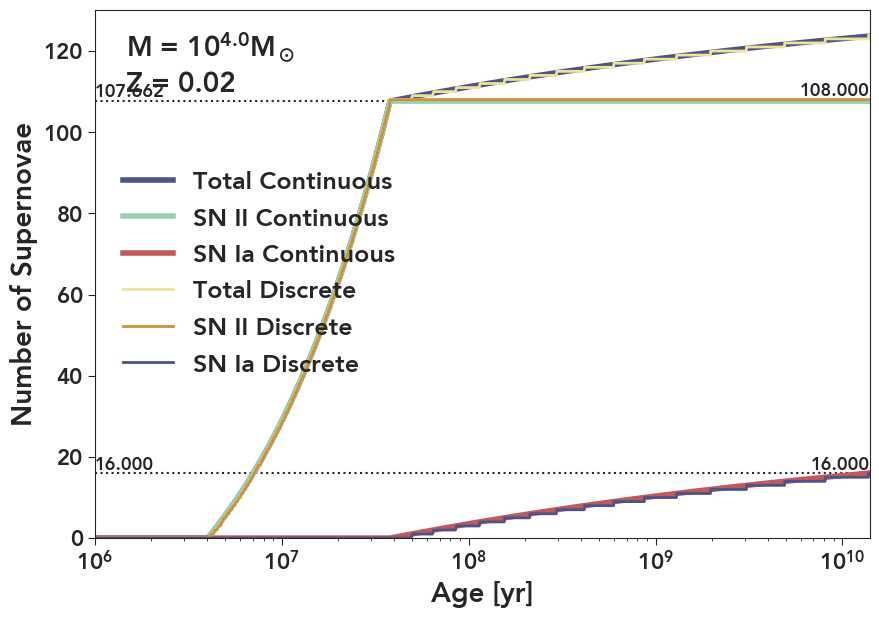

In [29]:
plot_history("N_SN", 10000, 0.02)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


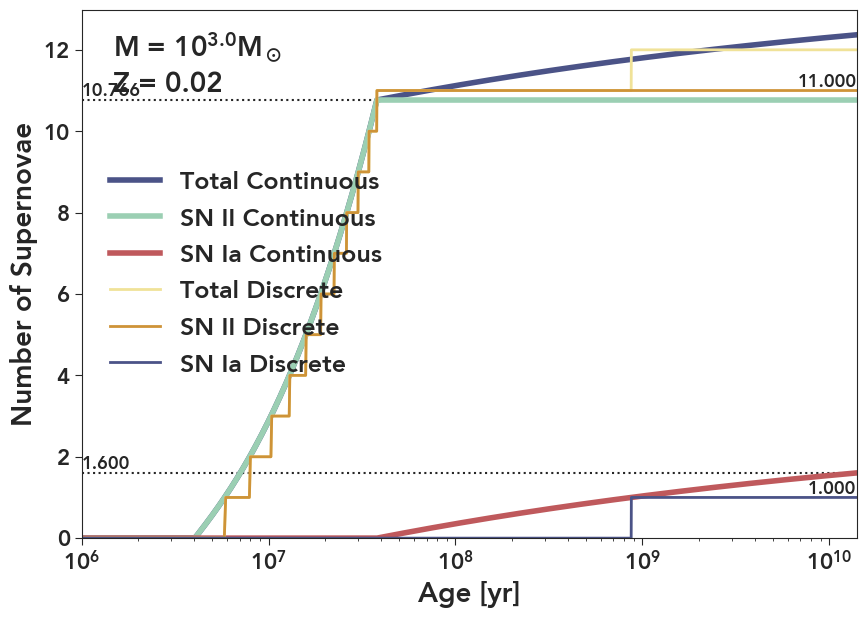

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


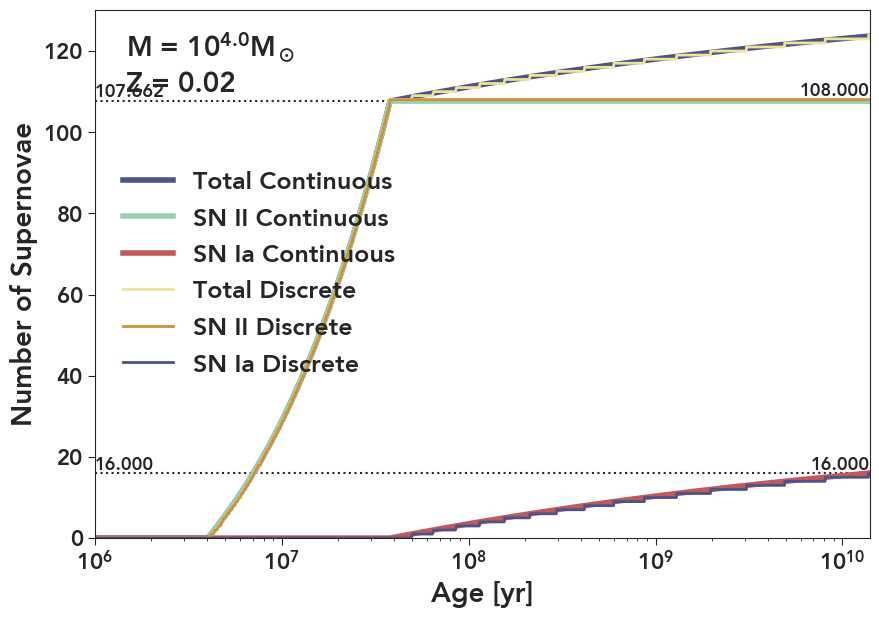

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


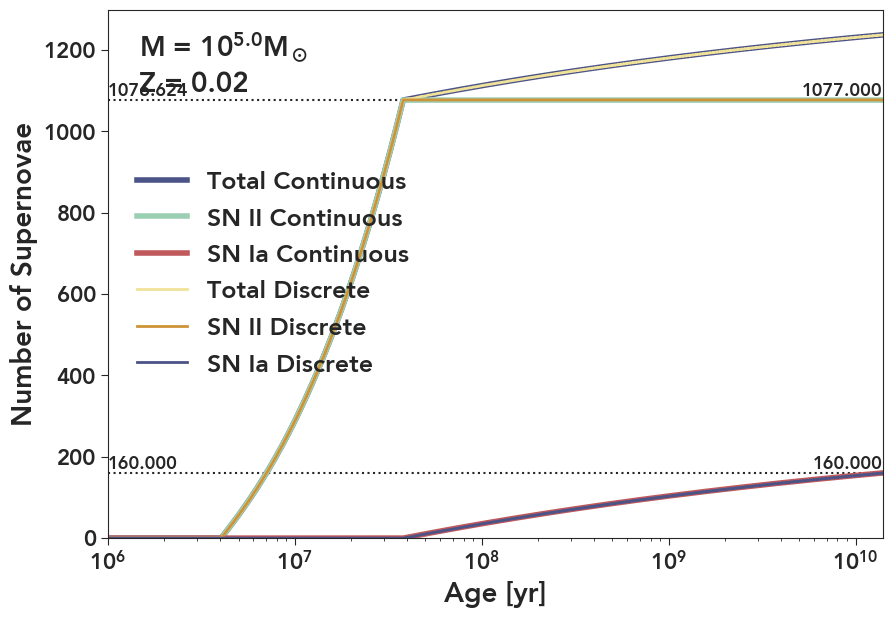

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


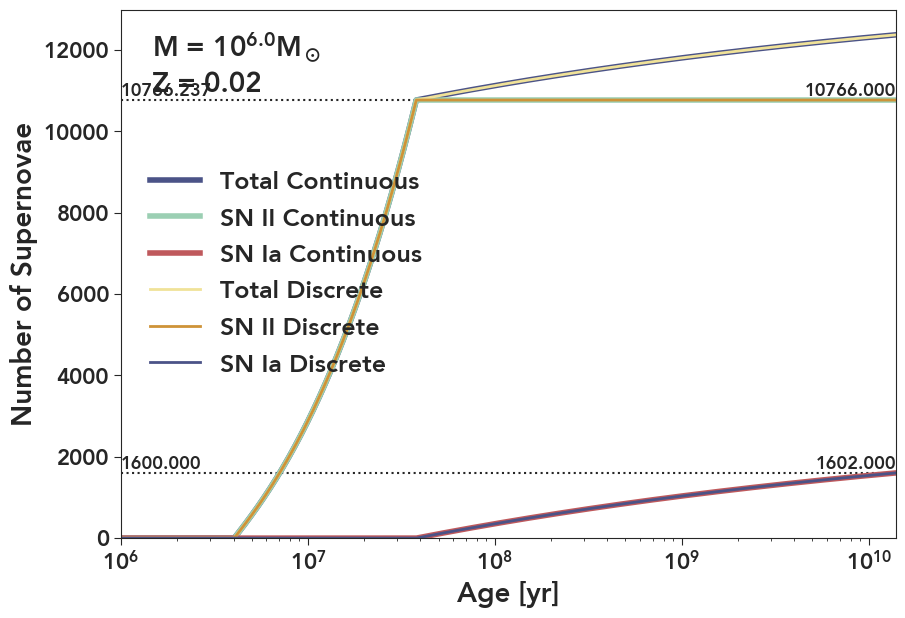

In [30]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N_SN", m, 0.02)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

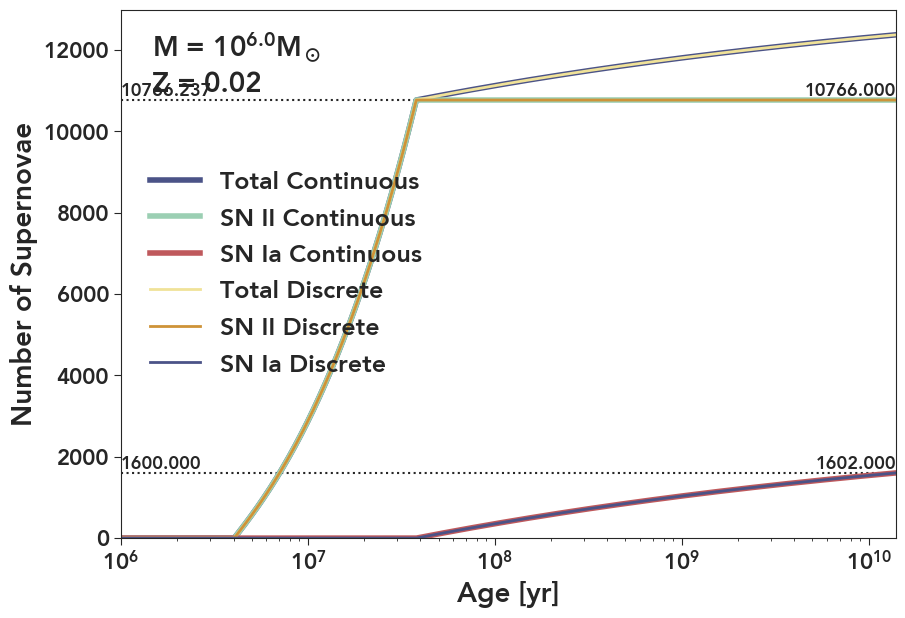

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


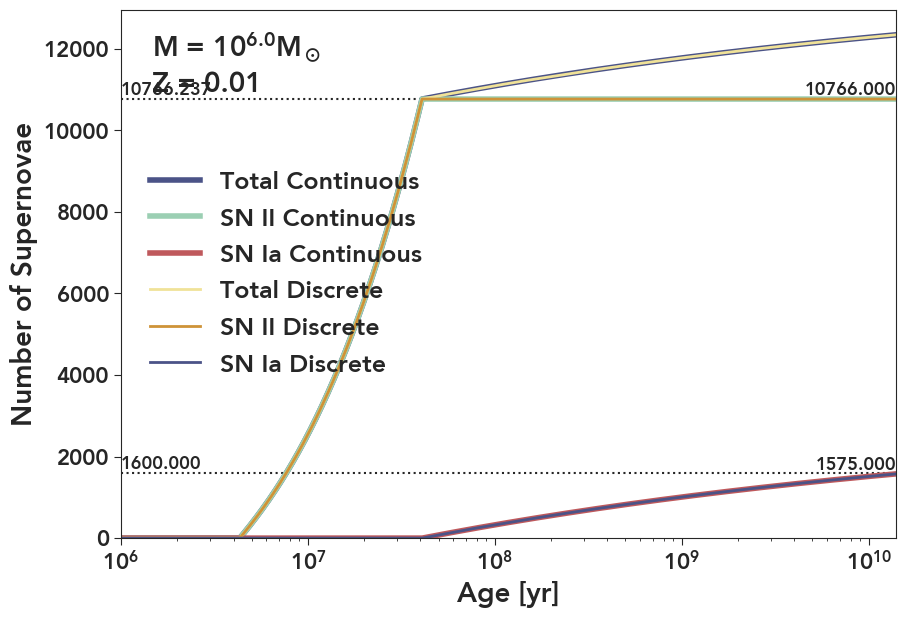

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


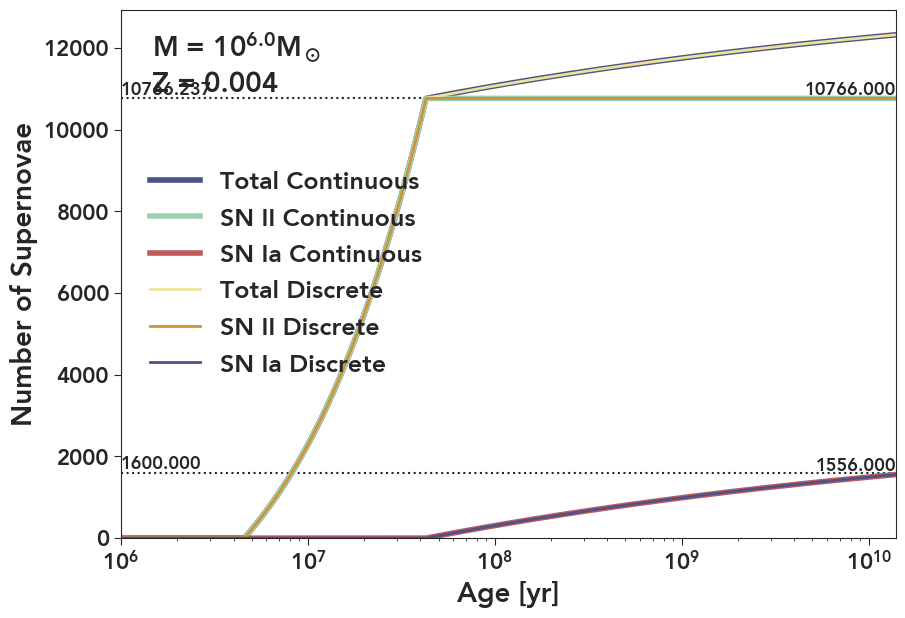

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


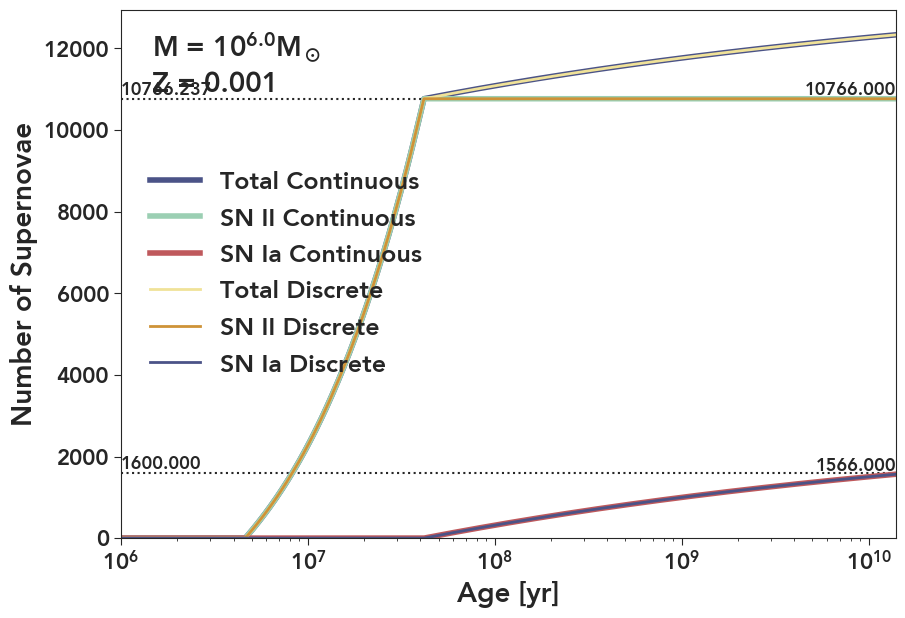

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


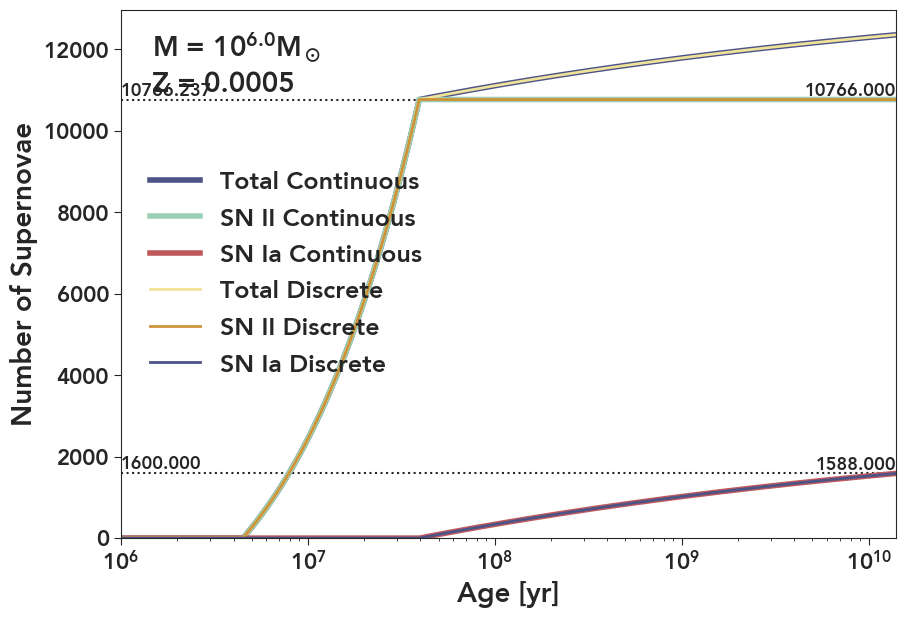

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


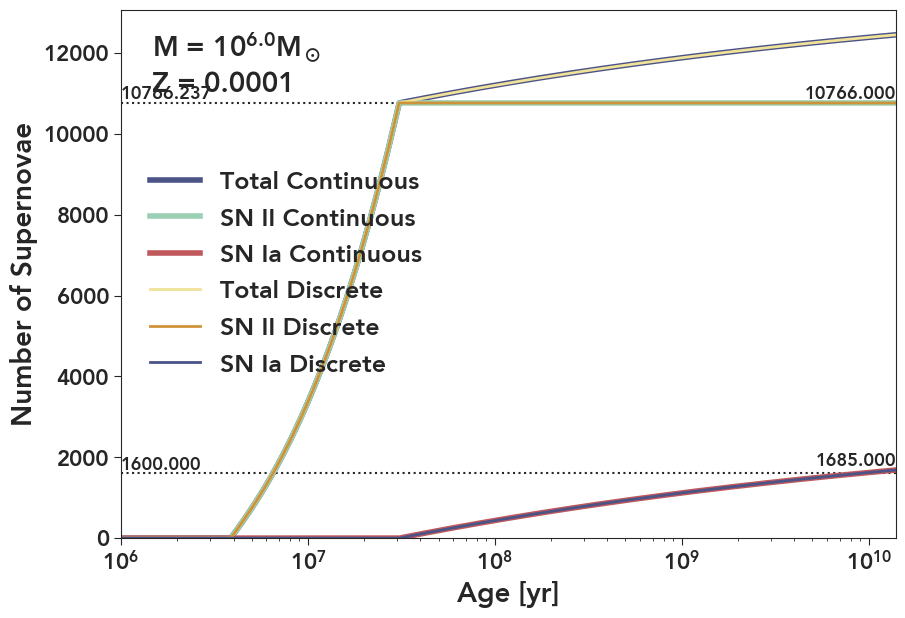

In [31]:
for z in times:
    plot_history("N_SN", 1E6, z)

IndexError: list index out of range

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


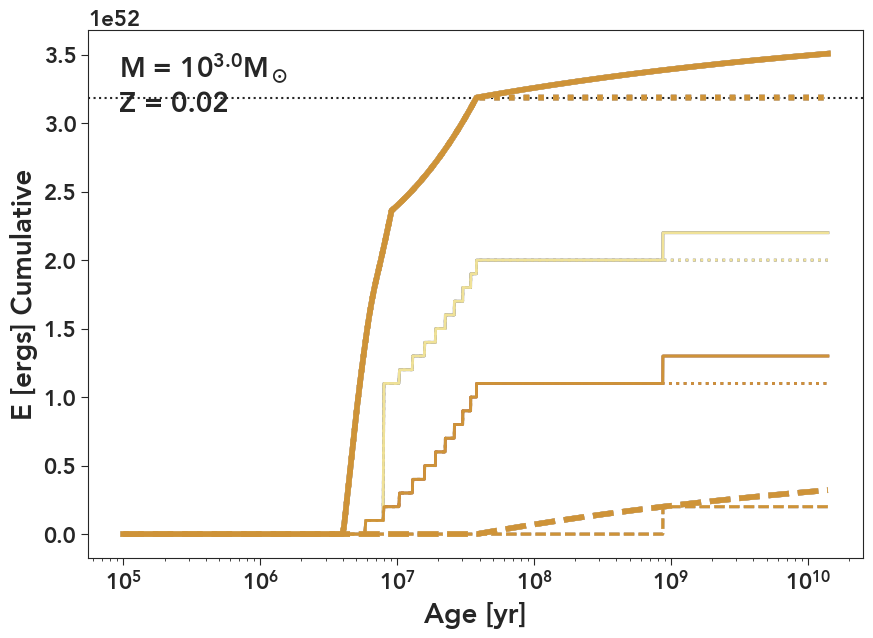

In [32]:
for m in [1E3, 1E4, 1E5, 1E6, 1E10]:
    plot_history_energy(m, 0.02, 10)

In [ ]:
m_test = 1E6
print(frac_E * m_test)
this_obj = SNHistory(m_test, 0.01, False, False)
print(this_obj.cumulative_sn_ii["E"][-1])

This is good! It was not good previously, and I think this is due to the timestep. In a given timestep, there is only one SN energy selected. This is chosen to be the mean of the mass at the beginning and end of the timestep. Previously we selected the mass at the end of the timestep, so this biased us to low energies.

In [ ]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_rates("N_SN", m, 0.02)

In [ ]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("Fe", m, 0.02)

In [ ]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("C", m, 0.02)

In [ ]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N", m, 0.02)

In [ ]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("total", m, 0.02)

In [ ]:
for elt in all_fields:
    plot_history(elt, 1E6, 0.02)

(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x1a1f632cc0>)

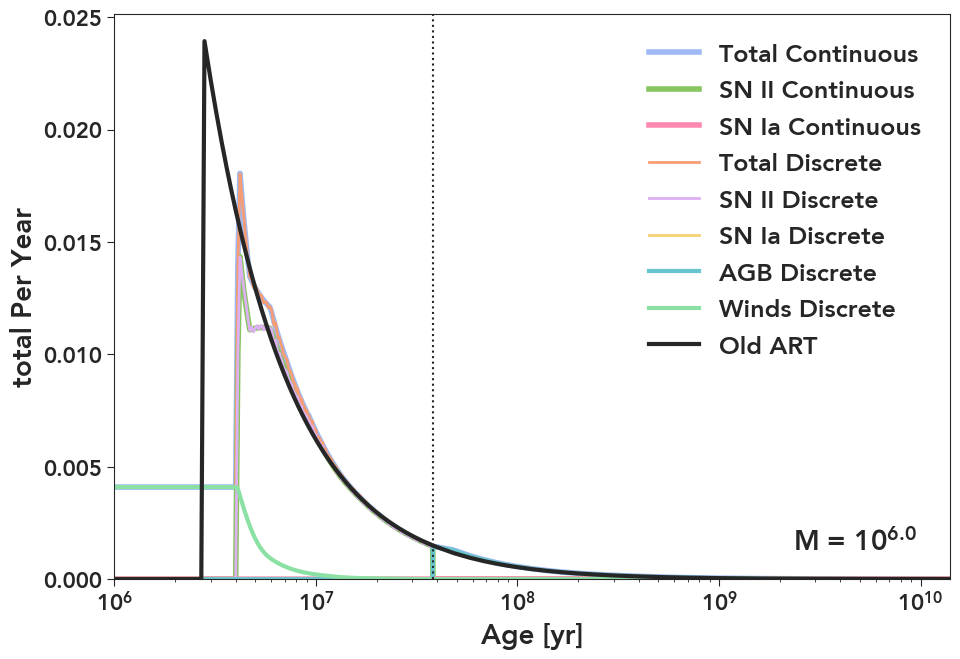

In [40]:
plot_rates("total", 1E6, 0.02)

(<Figure size 1000x700 with 1 Axes>,
 <matplotlib.axes._subplots.Axes_bplSubplot at 0x10bee45f8>)

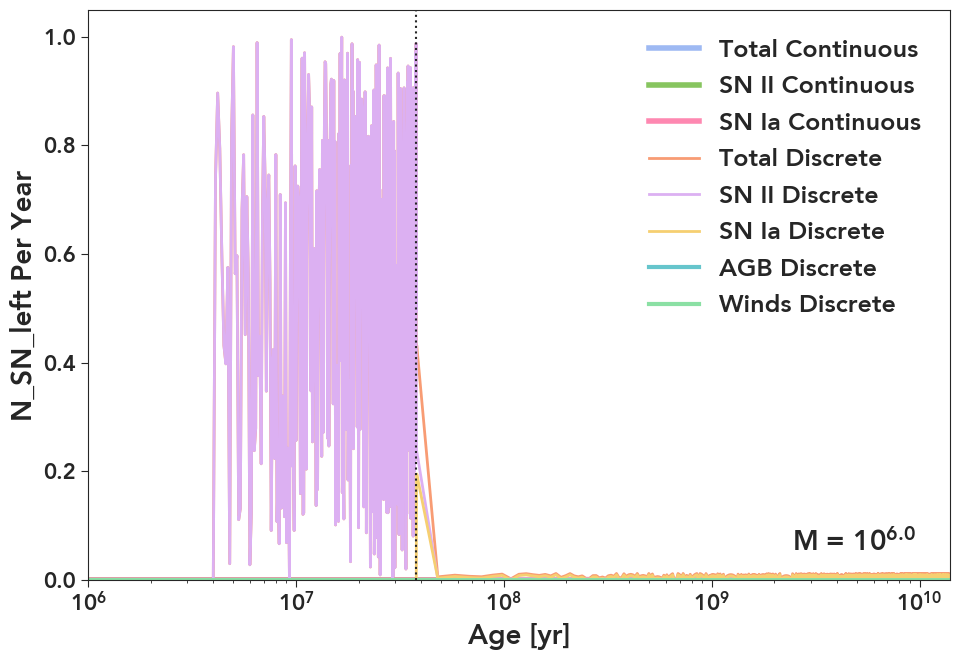

In [41]:
plot_rates("N_SN_left", 1E6, 0.02)

## Compare to previous ART prescription

In [42]:
"""
number_SNII = integrate( imf->f, snII.min_mass, snII.max_mass, 1e-6, 1e-9 );
snII_phys.number = number_SNII/(constants->Msun*total_mass);
snII_code.number = snII_phys.number*units->mass;

phi = dt/tage;
N_SN = phi*star_initial_mass[ipart] * snII_code.number;

"""


'\nnumber_SNII = integrate( imf->f, snII.min_mass, snII.max_mass, 1e-6, 1e-9 );\nsnII_phys.number = number_SNII/(constants->Msun*total_mass);\nsnII_code.number = snII_phys.number*units->mass;\n\nphi = dt/tage;\nN_SN = phi*star_initial_mass[ipart] * snII_code.number;\n\n'

In [43]:
sn_low = 3E6
sn_high = 1.5E7 + 3E6

old_number_snii = frac_N_SN_II  # calculated the same way


def old_sn_rate(age, mass):
    if age < sn_low:
        return 0
    if age > sn_high:
        return 0
    
    phi_per_dt = 1.0 / age
    rate = phi_per_dt * mass * old_number_snii
    return rate

def old_sn_energies(age, mass):
    return 1E51 * old_sn_rate(age, mass)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


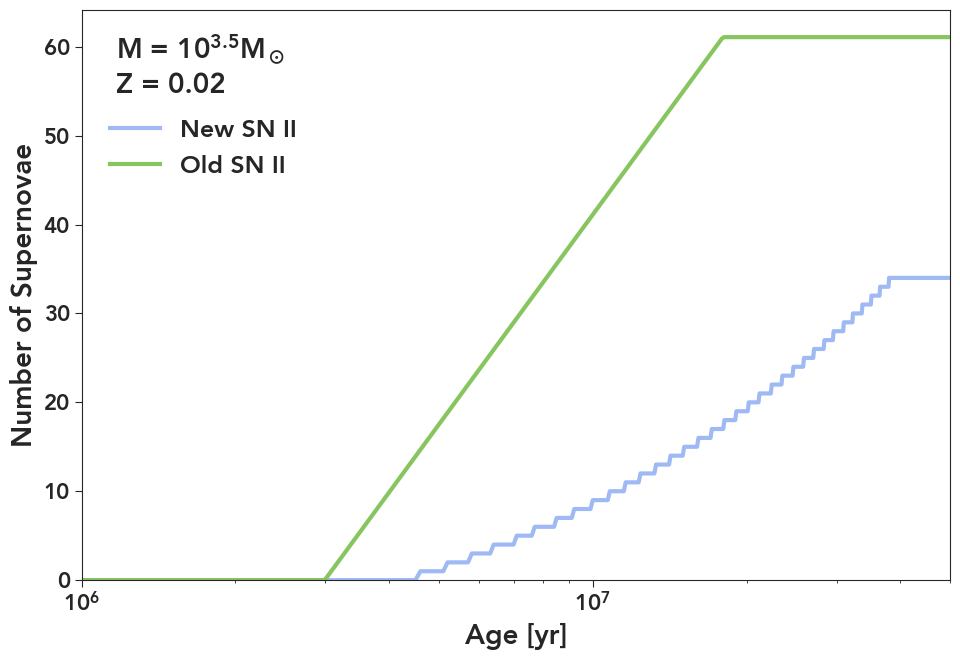

In [123]:
for mass in [10**3.5]:
#     fig, ax = plot_history("N_SN", m, 0.02)
    field = "N_SN"
    z = 0.02
    plot_times = times[z][1:]
    
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = 50E6
    
    ax.set_xscale("log")
    ax.add_labels("Age [yr]", "Number of Supernovae")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    

    expected_ii = frac_N_SN_II * mass
    expected_ia = frac_N_SN_Ia * mass
#     ax.axhline(expected_ii, ls=":")
#     ax.axhline(expected_ia, ls=":")
#     ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
#                 ha="left", va="bottom", fontsize=13)
#     ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
#                 ha="left", va="bottom", fontsize=13)

    
    lw = 2
    this_obj = SNHistory(mass, z, True, False)
    ax.plot(plot_times, this_obj.cumulative_sn_ii[field], label="New SN II")


    old_ages = np.logspace(6, 10.3, 1000)
    old_sn_rates = [old_sn_rate(a, mass) for a in old_ages]
    old_sn_cum = integrate.cumtrapz(x=old_ages, y=old_sn_rates, initial=0)
    
    ax.plot(old_ages, old_sn_cum, label="Old SN II")
#     ax.add_text(14E9, old_sn_cum[-1], "{:.3f}".format(old_sn_cum[-1]), 
#                 ha="right", va="bottom", fontsize=13)
    
    ax.legend(bbox_to_anchor=(0.0, 0.86), loc="upper left")
    ax.set_limits(left_limit, right_limit, 0, max(old_sn_cum)*1.05)
    fig.savefig("N_SN_comparison.png")

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


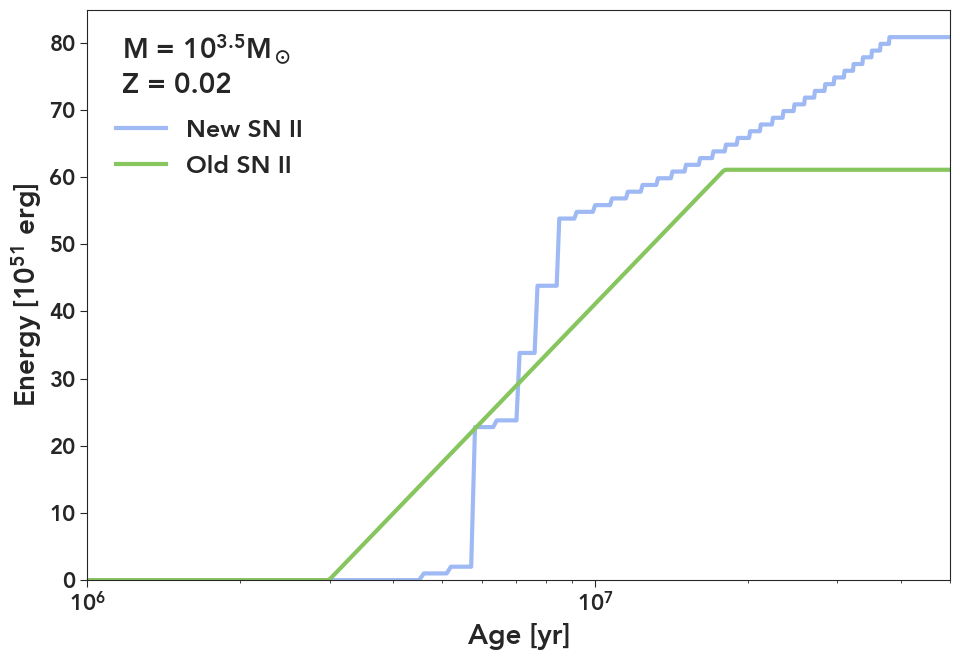

In [147]:
for mass in [10**3.5]:
#     fig, ax = plot_history("N_SN", m, 0.02)
    field = "E"
    z = 0.02
    plot_times = times[z][1:]
    
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = 50E6
    
    ax.set_xscale("log")
    ax.add_labels("Age [yr]", "Energy [$10^{51}$ erg]")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    

#     expected_ii = frac_N_SN_II * mass
#     expected_ia = frac_N_SN_Ia * mass
#     ax.axhline(expected_ii, ls=":")
#     ax.axhline(expected_ia, ls=":")
#     ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
#                 ha="left", va="bottom", fontsize=13)
#     ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
#                 ha="left", va="bottom", fontsize=13)

    
    lw = 2
    this_obj = SNHistory(mass, z, True, False)
    ax.plot(plot_times, np.array(this_obj.cumulative_sn_ii[field]) /1E51, label="New SN II")


    old_ages = np.logspace(6, 10.3, 1000)
    old_e_rates = [old_sn_energies(a, mass) for a in old_ages]
    old_e_cum = integrate.cumtrapz(x=old_ages, y=old_e_rates, initial=0) / 1E51
    
    ax.plot(old_ages, old_e_cum, label="Old SN II")
#     ax.add_text(14E9, old_sn_cum[-1], "{:.3f}".format(old_sn_cum[-1]), 
#                 ha="right", va="bottom", fontsize=13)
    
    ax.legend(bbox_to_anchor=(0.0, 0.86), loc="upper left")
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("E_comparison.png")

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


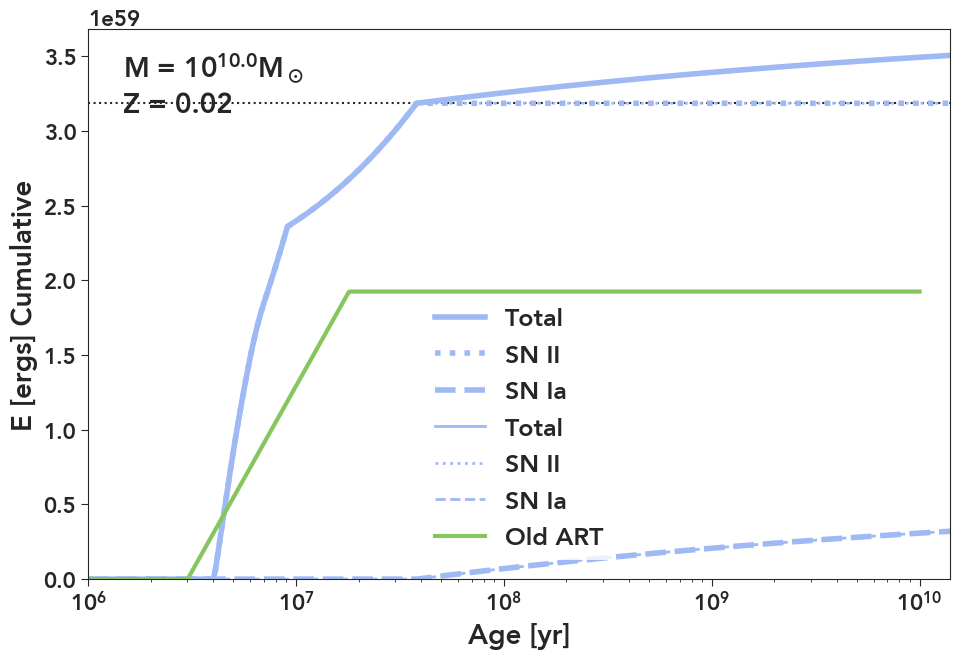

In [45]:
for m in [1E10]:
    fig, ax = plot_history_energy(m, 0.02, 1)
    
    old_ages = np.logspace(6, 10, 1000)
    old_e_rates = [old_sn_energies(a, m) for a in old_ages]
    old_e_cum = integrate.cumtrapz(x=old_ages, y=old_e_rates, initial=0)
    
    ax.plot(old_ages, old_e_cum, label="Old ART", c=bpl.color_cycle[1])
    
    ax.legend()
#     ax.set_limits(y_max=max(old_e_cum)*1.05)

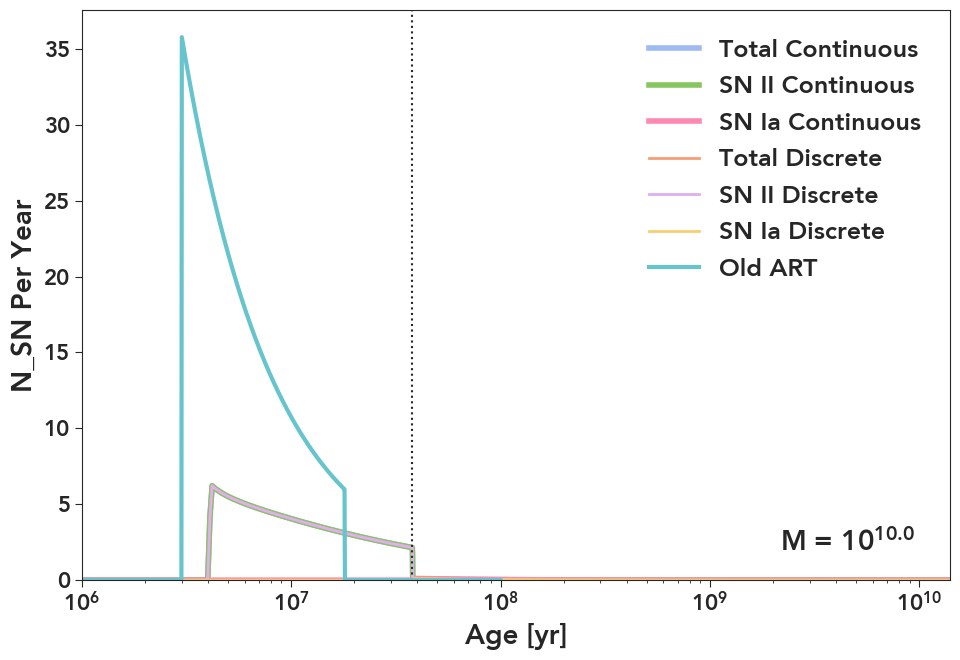

In [77]:
for m in [1E10]:
    fig, ax = plot_rates("N_SN", m, 0.02)
    
    old_ages = np.logspace(6, 8, 1000)
    old_sn_rates = [old_sn_rate(a, m) for a in old_ages]
    
    ax.plot(old_ages, old_sn_rates, label="Old ART")
    
    ax.legend()
    ax.set_limits(y_max=1.05*max(old_sn_rates))

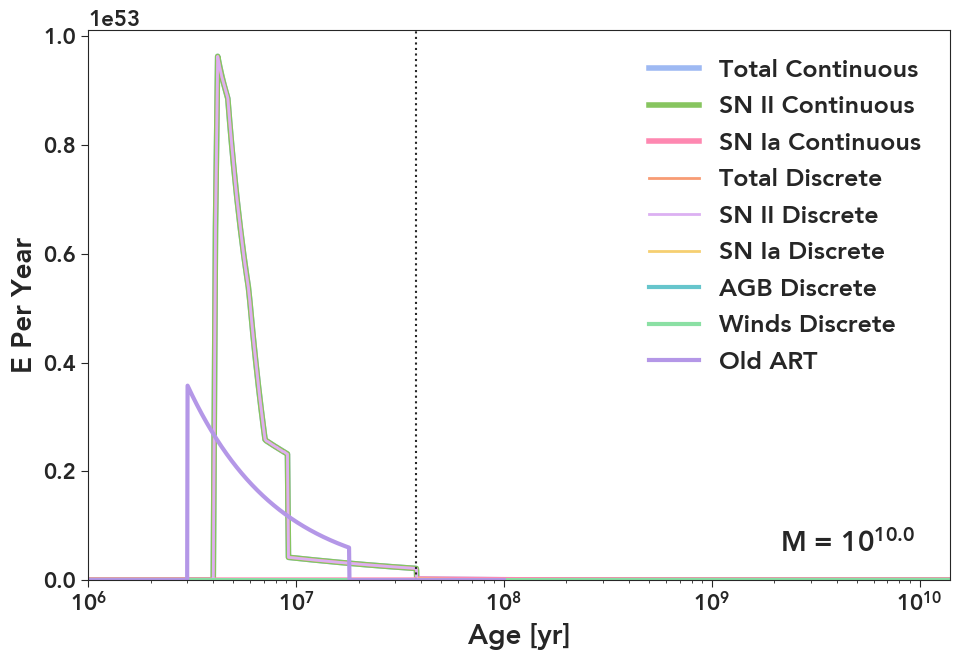

In [47]:
for m in [1E10]:
    fig, ax = plot_rates("E", m, 0.02)
    
    old_ages = np.logspace(6, 8, 1000)
    old_e_rates = [old_sn_energies(a, m) for a in old_ages]
    
    ax.plot(old_ages, old_e_rates, label="Old ART")
    
    ax.legend()

# Yields

In [48]:
from matplotlib import colors
from matplotlib import cm

In [49]:
def yield_agb_wrapper(z, m, elt):
    if elt == "Z":
        raw_z_yield = core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["Z_AGB"]]
        ca_yield = yield_agb_wrapper(z, m, "Ca")
        s_yield = yield_agb_wrapper(z, m, "S")
        fe_yield = yield_agb_wrapper(z, m, "Fe")
        return raw_z_yield + ca_yield + s_yield + fe_yield
    
    # implicit else
    if elt in ["S", "Ca", "Fe"]:
        return (z / 0.02) * solar_metallicities[elt] * core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["total"]]
    
    # implicit else
    return core.get_yields_raw_agb_py(z, m)[agb_idxs_yields[elt]]

In [50]:
norm = colors.LogNorm(vmin=1E-4, vmax=0.02)
mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
mappable.set_array([])

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


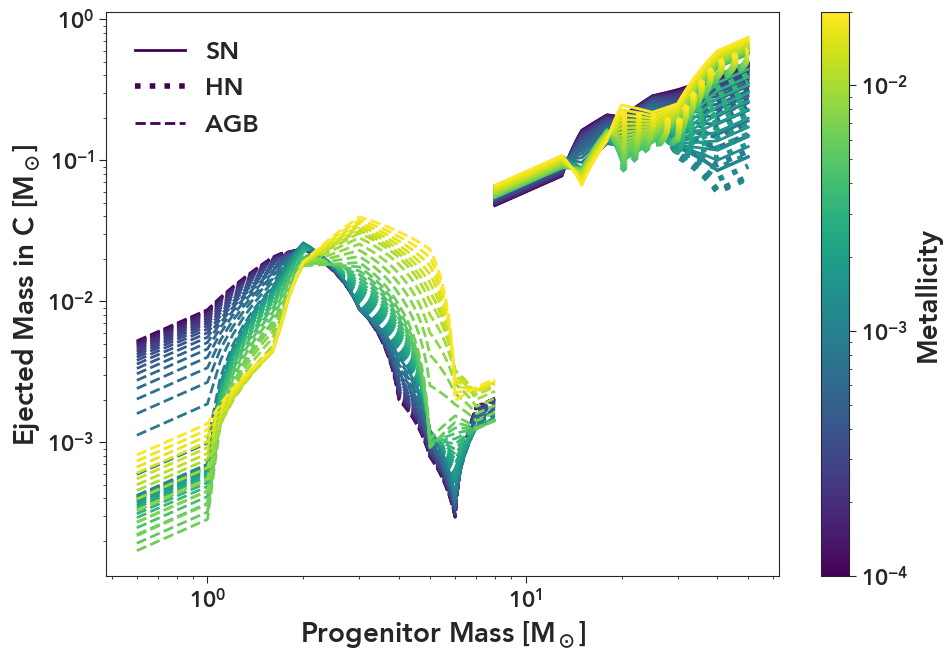

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


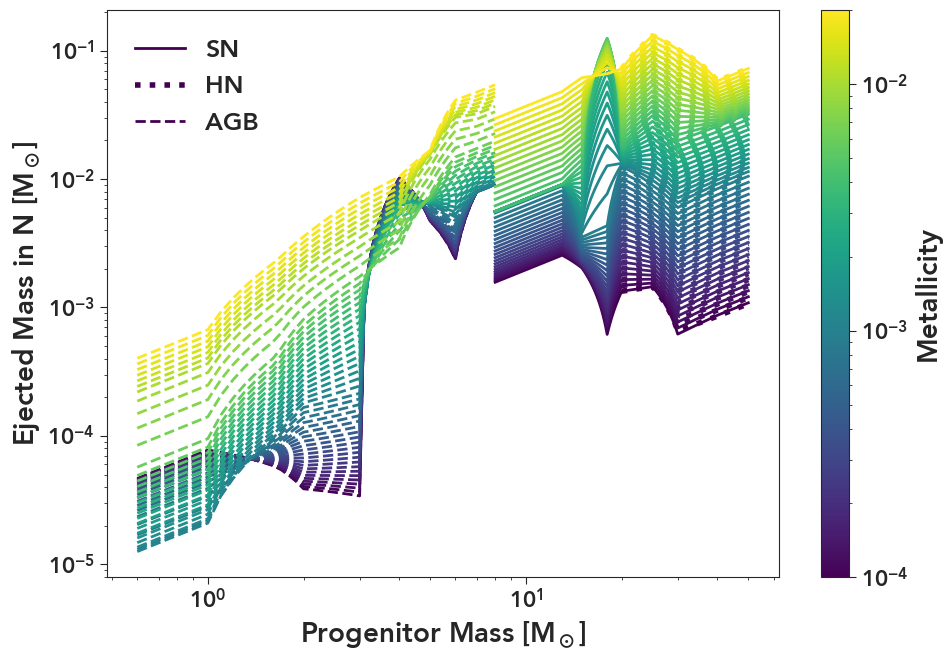

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


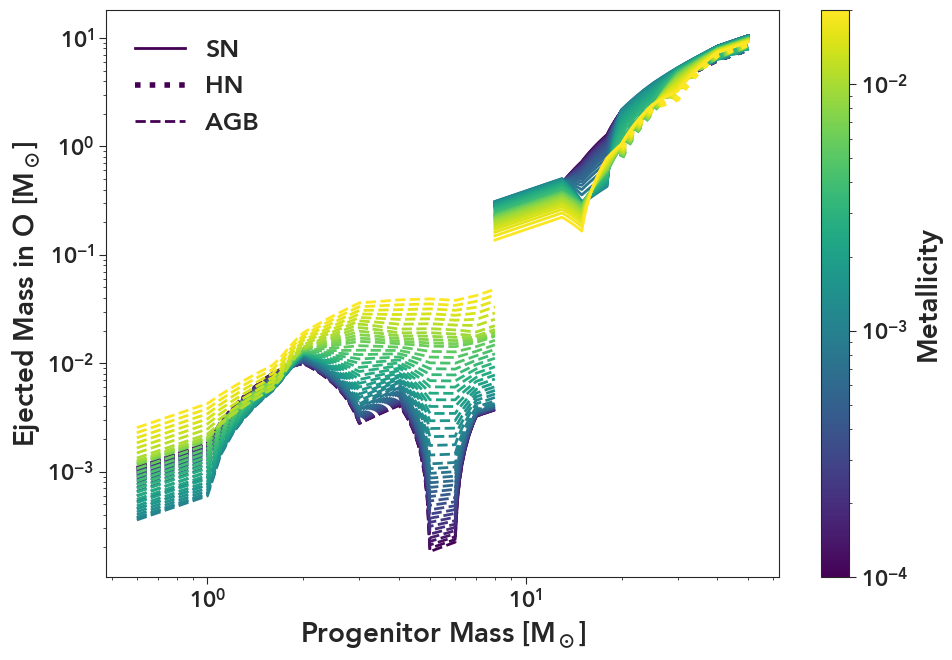

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


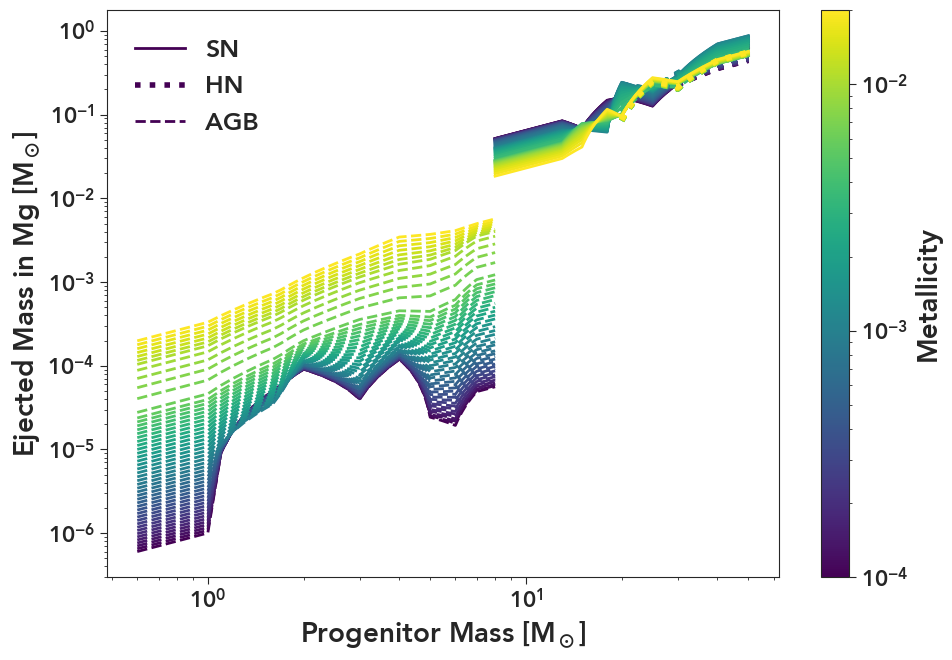

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


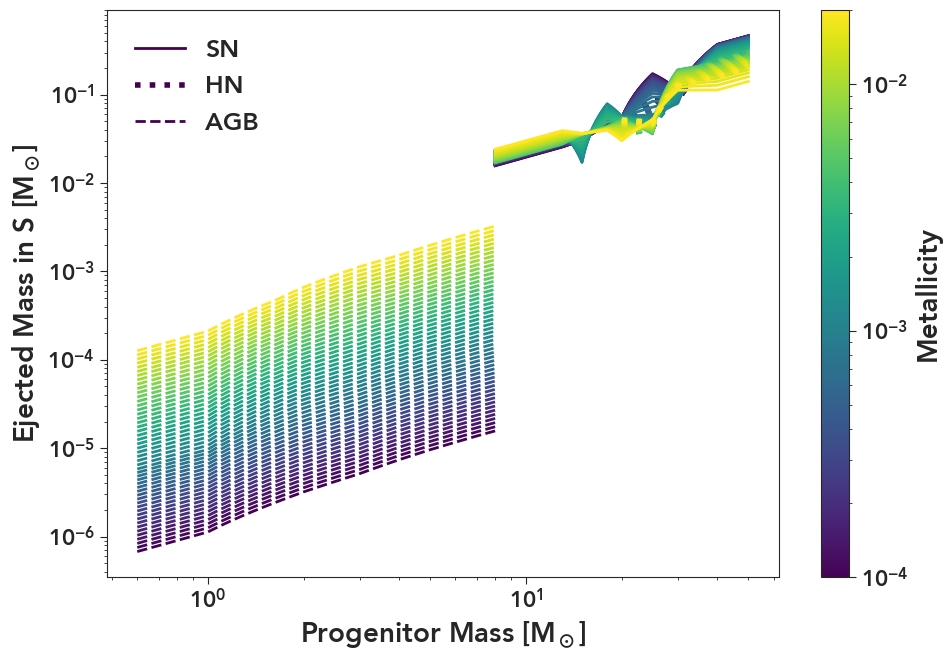

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


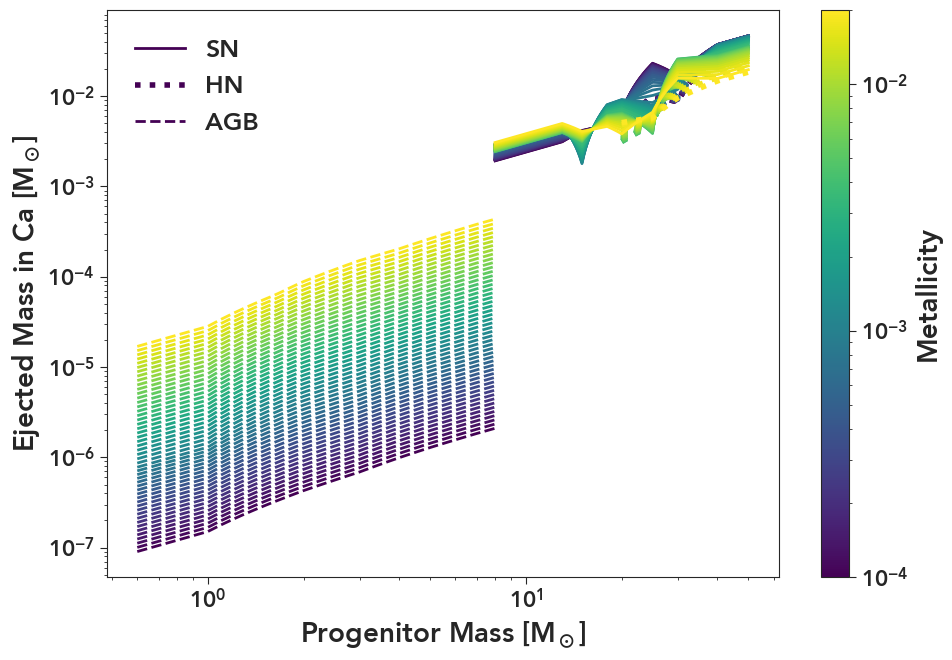

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


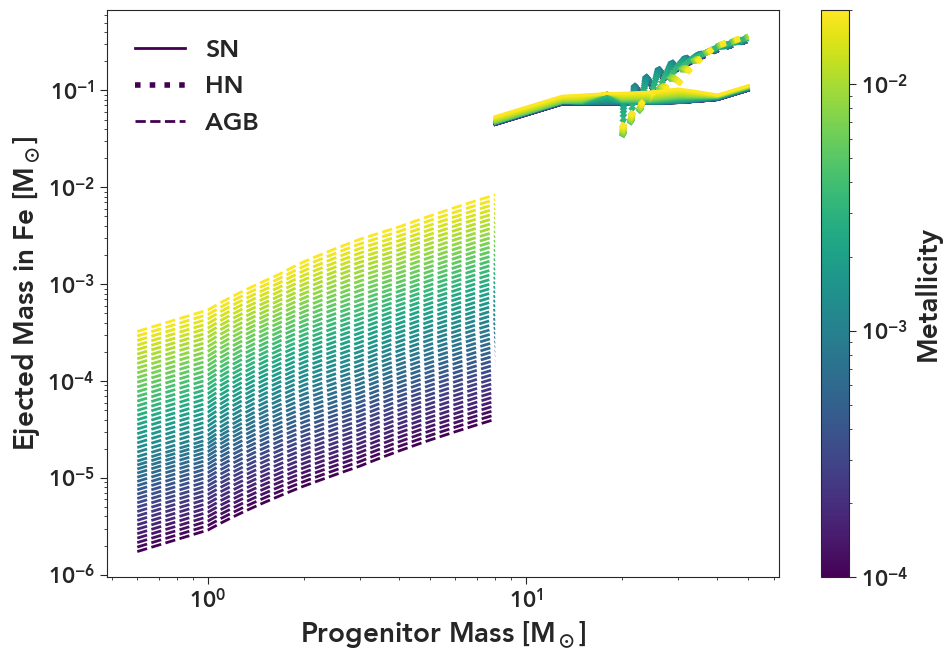

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


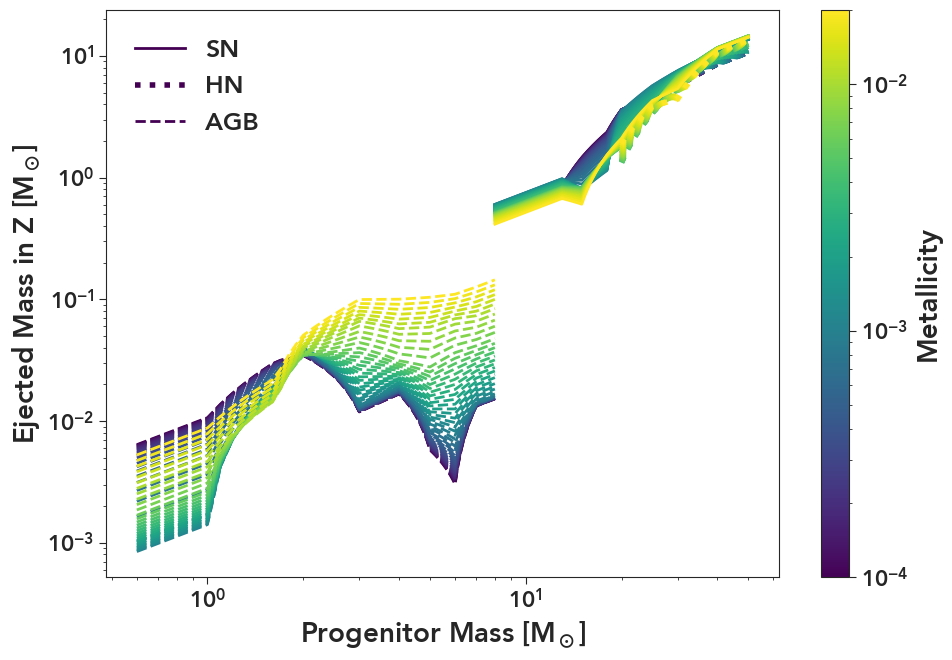

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


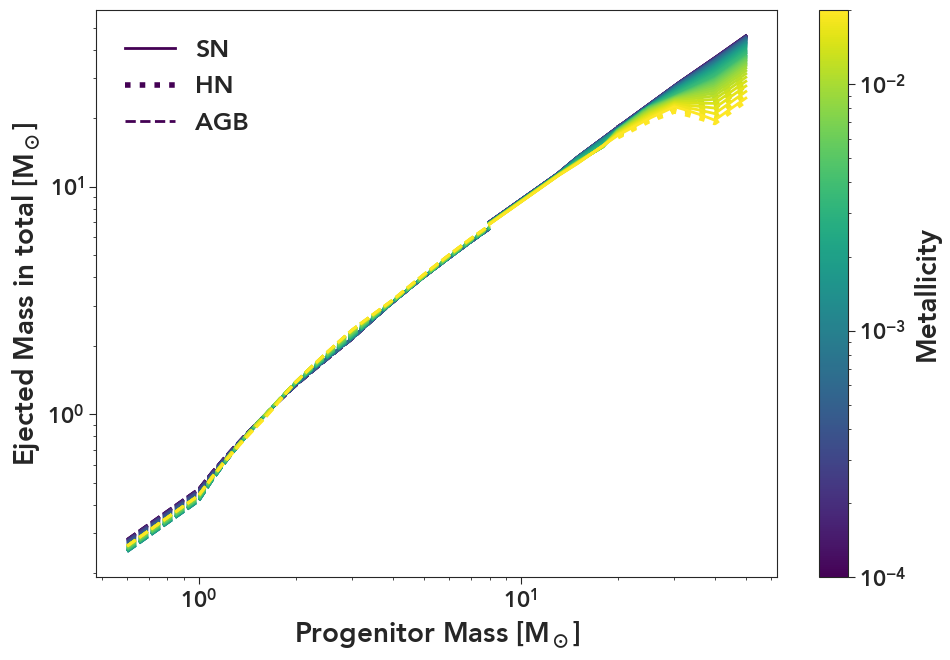

In [76]:
ls = {"AGB": "--", "SN": "-", "HN":":"}
lw = {"AGB": 2, "SN": 2, "HN":4}

ms = dict()
ms["AGB"] = np.arange(0.6, 8.01, 0.1)
ms["SN"] = np.arange(8.0, 50.01, 0.1)
ms["HN"] = np.arange(20.0, 50.01, 0.1)

for elt in elts + ["Z", "total"]:
    fig, ax = bpl.subplots()
    ax.add_labels("Progenitor Mass [$M_\odot$]", "Ejected Mass in {}".format(elt) + " [$M_\odot$]")
    
#     for z_idx, z in enumerate([0.0001, 0.001, 0.005, 0.01, 0.02]):
    for z_idx, z in enumerate(np.logspace(-4, np.log10(0.02), 50)):
        c = mappable.to_rgba(z)
        
        for func, label in zip([core.get_yields_raw_sn_ii_py,
                                core.get_yields_raw_hn_ii_py,
                                core.get_yields_raw_agb_py], 
                                   ["SN", "HN", "AGB"]):
            if label == "AGB":
                yields = [yield_agb_wrapper(z, m, elt) for m in ms[label]]
            else:
                yields = [func(z, m)[sn_ii_idxs[elt]] for m in ms[label]]



            if z_idx > 0:
                plot_label=None
            else:
                plot_label=label
            ax.plot(ms[label], yields, label=plot_label, ls=ls[label], lw=lw[label], c=c)
    
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    cbar = fig.colorbar(mappable)
    cbar.set_label("Metallicity")
    ax.legend()

# SN rates

In [52]:
dts = [times[0.02][idx+1] - times[0.02][idx] for idx in range(len(times[0.02]) - 1)]

In [53]:
rates = [snia_discrete.get_sn_ia_number_py(times[0.02][idx], dts[idx], lt.lifetime(8.0, 0.02)) 
         for idx in range(len(times[0.02]) - 1)]

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


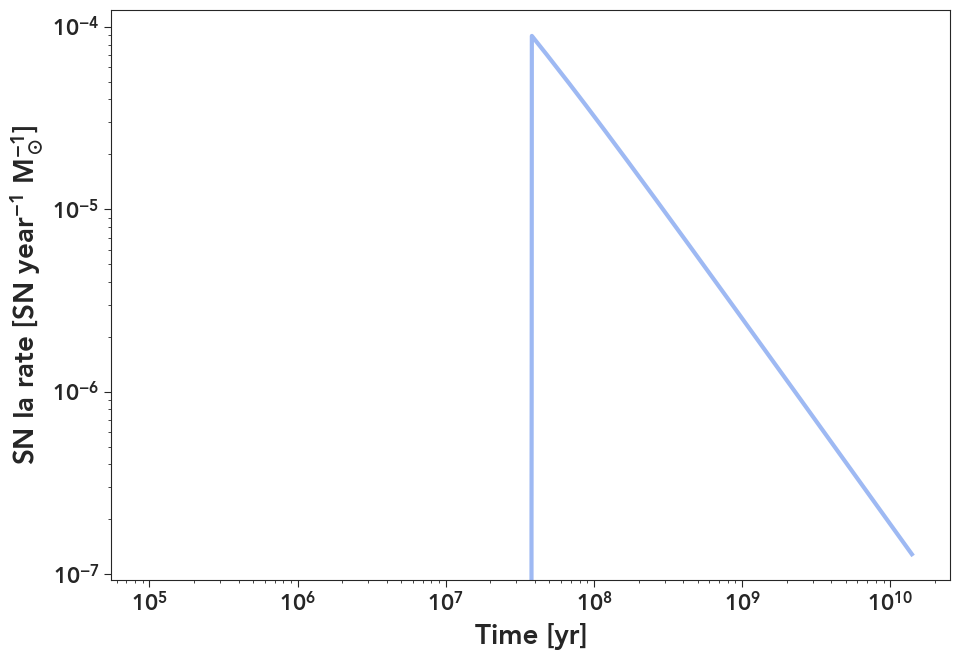

In [54]:
fig, ax = bpl.subplots()
ax.plot(times[0.02][:-1], rates)
ax.set_xscale("log")
ax.set_yscale("log")
ax.add_labels("Time [yr]", "SN Ia rate [SN year$^{-1}$ M$^{-1}_\odot$]")

In [55]:
test_times = np.arange(0, 1E10, 1E3)
for func in [snia_discrete.sn_ia_core_py,
             snia_continuous.sn_ia_core_py]:
    for t in tqdm(test_times):
        func(0.1, t, dt_sn, 1E6, 0.02, 40E6)

/Users/gillenb/miniconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [56]:
test_times = np.arange(0, 1E10, 1E3)
for func in [snii_discrete.get_ejecta_sn_ii_py,
             snii_continuous.get_ejecta_sn_ii_py]:
    for t in tqdm(test_times):
        func(0.1, 12, 8.1, 1E6, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [57]:
test_times = np.arange(0, 1E10, 1E3)
for t in tqdm(test_times):
    agb.get_ejecta_agb_py(34, 6, 1E6, 0.02, 1E-5, 1E-5, 1E-5)

/Users/gillenb/miniconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [80]:
for elt in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_discrete.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elt]])

178.896658875
2380.34394
3665.814875
6407.58375
278.0


In [81]:
for elt in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_continuous.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elt]])

179.8012657028239
2382.981927782483
3673.3910329044847
6417.089839015936
278.6215585249996


In [82]:
core.get_yields_raw_sn_ii_py(34, 0.02)

<cdata 'double *' 0x1a1d0e3790>

In [83]:
core.get_yields_raw_sn_ii_py(0.02, 34)[0]

0.38972439999999997

In [84]:
n_sn = core.imf_integral_py(29.695113385786325, 29.79659090887414) * 297842.737699386

In [85]:
m_sun_to_code = 0.24946558475494385 / 297842.737699386

In [86]:
n_sn * m_sun_to_code**2

1.9935291193578974e-12

In [87]:
snii_continuous.get_ejecta_sn_ii_py(0.1, 12, 8.1, 1E6, 0.02)[0]

389.87375439636094

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


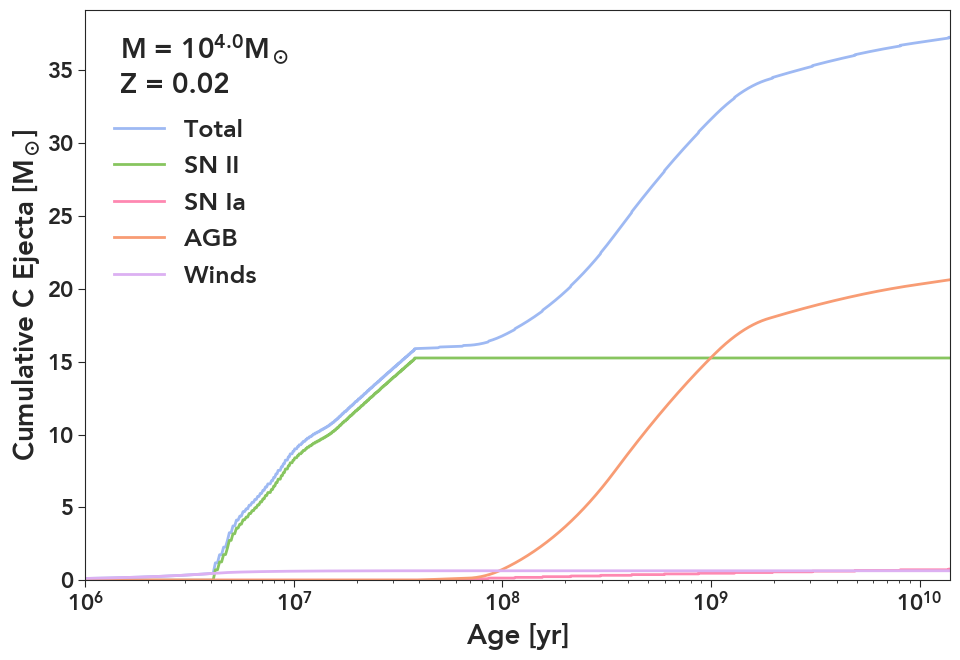

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


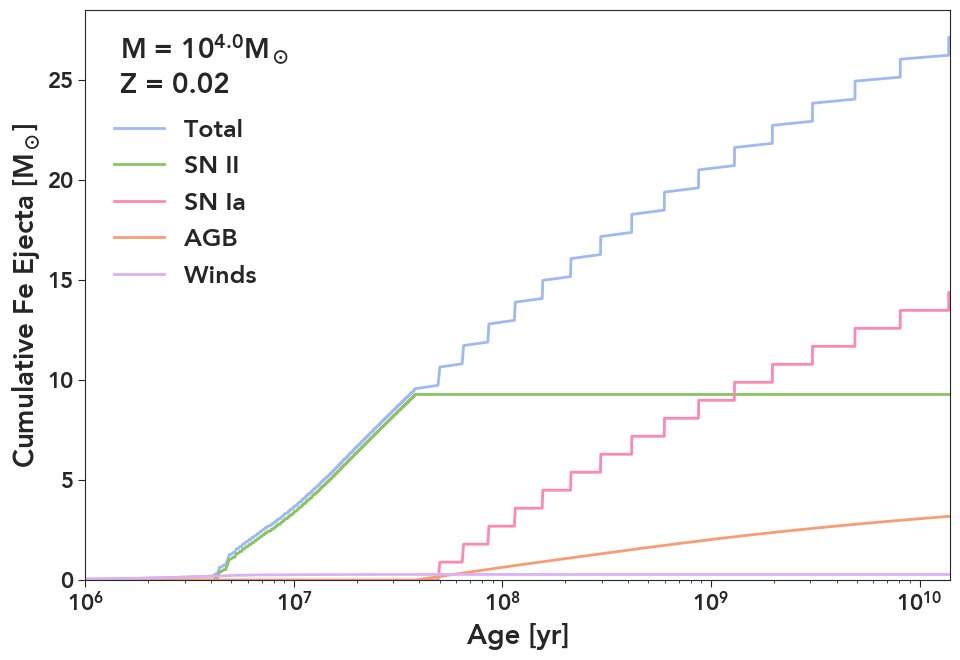

In [164]:
for field in  ["C", "Fe"]:
    mass = 10**4
    z = 0.02
    verbose = False

    plot_times = times[z][1:]
    fig, ax = bpl.subplots()

    left_limit = 1E6
    right_limit = max(plot_times)

    ax.set_xscale("log")
    #     if field not in ["N_SN"]:
    #         ax.set_yscale("log")
    if field == "E":
        label = "E [ergs] Cumulative"
    elif field =="N_SN":
        label = "Number of Supernovae"
    else: 
        label = "Cumulative " + field + " Ejecta [$M_\odot$]"
    ax.add_labels("Age [yr]", label)
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")

    if field == "E":
        ax.axhline(frac_E * mass, ls=":")
    if field == "N_SN":
        expected_ii = frac_N_SN_II * mass
        expected_ia = frac_N_SN_Ia * mass
        ax.axhline(expected_ii, ls=":")
        ax.axhline(expected_ia, ls=":")
        ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
                    ha="left", va="bottom", fontsize=13)
        ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
                    ha="left", va="bottom", fontsize=13)
    if field == "total":
        art_rates = [art_mass_loss_rate(t, mass) for t in plot_times]
        art_cumulative = integrate.cumtrapz(x=plot_times, y=art_rates, initial=0)
        ax.plot(plot_times, art_cumulative, label="Old ART", c=bpl.almost_black)

    for label in ["Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete, verbose)
        ax.plot(plot_times, this_obj.cumulative[field], lw=lw, label="Total ")
        ax.plot(plot_times, this_obj.cumulative_sn_ii[field], lw=lw, label="SN II")
        ax.plot(plot_times, this_obj.cumulative_sn_ia[field], lw=lw, label="SN Ia")

    if field != "N_SN":
        ax.plot(plot_times, this_obj.cumulative_agb[field], lw=lw, label="AGB")
        ax.plot(plot_times, this_obj.cumulative_winds[field], lw=lw, label="Winds")

    if field == "N_SN":  
        true_sn_ii = this_obj.cumulative_sn_ii[field][-1]
        ax.add_text(right_limit, true_sn_ii, "{:.3f}".format(true_sn_ii), 
                    ha="right", va="bottom", fontsize=13)

        true_sn_ia = this_obj.cumulative_sn_ia[field][-1]
        ax.add_text(right_limit, true_sn_ia, "{:.3f}".format(true_sn_ia), 
                    ha="right", va="bottom", fontsize=13)

    ax.legend(bbox_to_anchor=(0.0, 0.86), loc="upper left", frameon=False)


    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("test_{}.png".format(field))


In [166]:
from astropy import units as u

In [167]:
n_step = 13.7 * u.Gyr / (10 * u.Myr)

In [168]:
time_per_step = 5 * u.hour + 4 * u.minute

In [171]:
total_time = time_per_step * n_step

In [172]:
total_time.to(u.year)

<Quantity 0.79184729 yr>